In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np



%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [16]:
df_analyse=pd.read_csv('../data/processed/COVID_small_sync_timeline_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,doubling every day,doubling every 2 days,doubling every 4 days,doubling every 10 days,India,Germany,France,Spain,US,date
0,100.0,100.000000,100.000000,100.000000,102.0,130.0,130.0,120.0,104.0,0
1,200.0,141.421356,118.920712,107.177346,113.0,159.0,191.0,165.0,174.0,1
2,400.0,200.000000,141.421356,114.869835,119.0,196.0,204.0,222.0,222.0,2
3,800.0,282.842712,168.179283,123.114441,142.0,262.0,288.0,259.0,337.0,3
4,1600.0,400.000000,200.000000,131.950791,156.0,482.0,380.0,400.0,451.0,4


In [17]:
country_list=df_analyse.columns[1:]

In [18]:
def quick_plot(x_in, df_input,y_scale='log',slider=False):
  
    fig = go.Figure()

    for each in df_input.columns:
        fig.add_trace(go.Scatter(
                        x=x_in,
                        y=df_input[each],
                        name=each,
                        opacity=0.8))
    
    fig.update_layout(autosize=True,
        width=1024,
        height=768,
        font=dict(
            family="PT Sans, monospace",
            size=18,
            color="#7f7f7f"
            )
        )
    fig.update_yaxes(type=y_scale),
    fig.update_xaxes(tickangle=-45,
                 nticks=20,
                 tickfont=dict(size=14,color="#7f7f7f")
                )
    if slider==True:
        fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()
      
    

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
quick_plot(df_analyse.date,
           df_analyse.iloc[:,4:-1],
           y_scale='log',
           slider=True)

# Fitting a polynomial curve

In [21]:
df_poly_check=df_analyse.iloc[0:27,3:-1].reset_index()
df_poly_check.head()

,index,doubling every 10 days,India,Germany,France,Spain,US
0,0,100.000000,102.0,130.0,130.0,120.0,104.0
1,1,107.177346,113.0,159.0,191.0,165.0,174.0
2,2,114.869835,119.0,196.0,204.0,222.0,222.0
3,3,123.114441,142.0,262.0,288.0,259.0,337.0
4,4,131.950791,156.0,482.0,380.0,400.0,451.0


In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [23]:
y=df_poly_check[['India','Germany','France','Spain','US']].unstack().sort_index(axis=0,level=1)

In [24]:
y.head()

India    0    102.0
Germany  0    130.0
France   0    130.0
Spain    0    120.0
US       0    104.0
dtype: float64

In [25]:
test_points=28
y_train=y[0:-test_points-1]
y_test=y[-test_points:]

In [26]:
X_train=np.arange(len(y_train)).reshape(-1, 1)/4.0 
X_test=np.arange(len(y_train),len(y_train)+test_points).reshape(-1, 1)/4.0

In [27]:
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn;
seaborn.set(rc={'figure.figsize':(16,8)})  # plot formatting, prepare for subplot

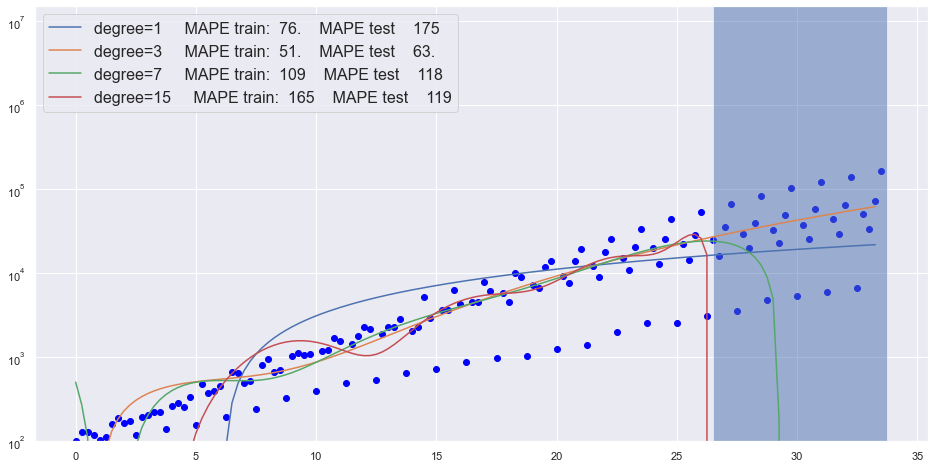

In [28]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(np.arange(len(y))/4,y, color='blue')
ax1.axvspan((len(y)-test_points-1)/4, len(y)/4, facecolor='b', alpha=0.5)

for degree in [1,3,7,15]:
    y_hat_insaple=PolynomialRegression(degree).fit(X_train, y_train).predict(X_train)
    y_hat_test = PolynomialRegression(degree).fit(X_train, y_train).predict(X_test)



    X_plot=np.concatenate((X_train, X_test), axis=None)
    y_plot=np.concatenate((y_hat_insaple, y_hat_test), axis=None)

    ax1.plot(X_plot, y_plot, label='degree={0}'.format(degree)+ 
                 '     MAPE train:  ' + str(mean_absolute_percentage_error(y_hat_insaple, y_train))[0:3]
                 +'    MAPE test    ' +str(mean_absolute_percentage_error(y_hat_test, y_test))[0:3]) 

ax1.set_ylim(100, 15000000)
ax1.set_yscale('log')
ax1.legend(loc='best',
           prop={'size': 16});